# About the data

Dataset description: 

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from datetime import datetime
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC



%matplotlib inline


In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.shape

(284807, 31)

In [4]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

There is a class imbalance problem here. We can address the class imbalance in two ways. We can downsample the majority class, or upsample the minority class.  Downsampling is going to be a much smaller dataset.

In [3]:
# Separate majority and minority classes
df_majority = df[df.Class==0]
df_minority = df[df.Class==1]

# Downsampling

In [4]:
# Downsample majority class# Downs 
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority))    # to match minority class
                                
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.Class.value_counts()

1    492
0    492
Name: Class, dtype: int64

In [8]:
df_downsampled.shape

(984, 31)

In [5]:
X = df_downsampled.loc[:, ~df_downsampled.columns.isin(['Class'])]
Y = df_downsampled['Class']

X.shape, Y.shape

((984, 30), (984,))

In [125]:
# Check the Correlation Matrix for the features

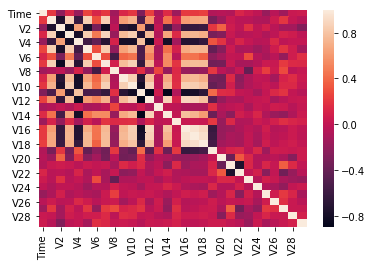

In [124]:
corr_mat = X.corr()
sns.heatmap(corr_mat)
plt.show()

Looks like many features are highly correlated. So need to do PCA.

In [99]:
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=30)
X_pca = pd.DataFrame(pca.fit_transform(X_std))

print(
    'The percentage of total variance in the dataset explained by each component from Sklearn PCA.\n',
    pca.explained_variance_ratio_.cumsum()
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [ 0.37590517  0.47063029  0.53888702  0.59464604  0.64580437  0.68617875
  0.72334862  0.75874167  0.79212011  0.82167302  0.84818122  0.8731204
  0.89446113  0.91453555  0.9290941   0.94294864  0.95440879  0.96372365
  0.97171621  0.97721043  0.98261722  0.9862797   0.98916541  0.99183578
  0.99391666  0.99583425  0.99744667  0.99874762  0.99959623  1.        ]


Lets consider we want features which can explain 92% variance

In [100]:
pca = PCA(n_components=15)
X_pca = pd.DataFrame(pca.fit_transform(X_std))

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [ 0.37590517  0.47063029  0.53888702  0.59464604  0.64580437  0.68617875
  0.72334862  0.75874167  0.79212011  0.82167302  0.84818122  0.8731204
  0.89446113  0.91453555  0.9290941 ]


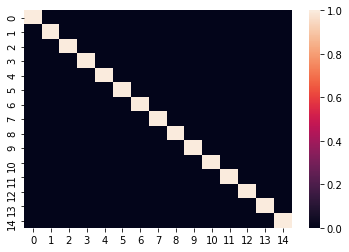

In [111]:
corr_mat = X_pca.corr()
sns.heatmap(corr_mat)
plt.show()

split the data after PCA

In [101]:
X_train, X_test, Y_train , Y_test = train_test_split(X_pca,Y,test_size=0.2, stratify = Y )
print(X_train.shape)
print(X_test.shape)

(787, 15)
(197, 15)


In [102]:
bnb = BernoulliNB()
Y_pred = cross_val_predict(bnb, X_train, Y_train, cv=5)
#print(Y_pred.shape)
bnb_train_precision, bnb_train_recall, thresholds = precision_recall_curve(Y_train, Y_pred)

print(auc(bnb_train_precision, bnb_train_recall))

conf_mat = confusion_matrix(Y_train, Y_pred)
#print(conf_mat)
print('Precision from Confusion Matrix ', conf_mat[1,1] / (conf_mat[1,1]+conf_mat[0,1]) )
print('Recall from Confusion Matrix ', conf_mat[1,1] / (conf_mat[1,1]+conf_mat[1,0]) )

print(classification_report(Y_train, Y_pred))

0.431458331097
Precision from Confusion Matrix  0.968652037618
Recall from Confusion Matrix  0.786259541985
             precision    recall  f1-score   support

          0       0.82      0.97      0.89       394
          1       0.97      0.79      0.87       393

avg / total       0.89      0.88      0.88       787



In [103]:

Y_pred = cross_val_predict(bnb, X_test, Y_test, cv=5)
#print(Y_pred.shape)
bnb_test_precision, bnb_test_recall, thresholds = precision_recall_curve(Y_test, Y_pred)


print(auc(bnb_test_precision, bnb_test_recall))

conf_mat = confusion_matrix(Y_test, Y_pred)
#print(conf_mat)
print('Precision from Confusion Matrix ', conf_mat[1,1] / (conf_mat[1,1]+conf_mat[0,1]) )
print('Recall from Confusion Matrix ', conf_mat[1,1] / (conf_mat[1,1]+conf_mat[1,0]) )

0.431494737244
Precision from Confusion Matrix  0.953488372093
Recall from Confusion Matrix  0.828282828283


# Try with  Logistic Regression

In [104]:
logreg = LogisticRegression()
Y_pred = cross_val_predict(logreg, X_train, Y_train, cv=5)

log_train_precision, log_train_recall, thresholds = precision_recall_curve(Y_train, Y_pred)

print(auc(log_train_precision, log_train_recall))


0.460784100909


In [105]:
Y_pred = cross_val_predict(logreg, X_test, Y_test, cv=5)
#print(Y_pred.shape)
logreg_test_precision, logreg_test_recall, thresholds = precision_recall_curve(Y_test, Y_pred)

print(auc(logreg_test_precision, logreg_test_recall))


0.453341638621


# Try Lasso Regression

In [106]:
lasso = LogisticRegressionCV(penalty='l1', solver = 'liblinear')
Y_pred = cross_val_predict(lasso, X_train, Y_train, cv=5)

lasso_train_precision, lasso_train_recall, thresholds = precision_recall_curve(Y_train, Y_pred)

print(auc(lasso_train_precision, lasso_train_recall))


0.461405455128


In [107]:
Y_pred = cross_val_predict(lasso, X_test, Y_test, cv=5)

lasso_test_precision, lasso_test_recall, thresholds = precision_recall_curve(Y_test, Y_pred)

print(auc(lasso_test_precision, lasso_test_recall))

0.458714043993


In [126]:
lasso.fit(X_train, Y_train)

print(lasso.coef_)

[[ 2.15363497 -0.33725936  0.35906563 -0.71364875 -1.81406276  0.91272739
  -0.38515949  0.21378339 -0.48616278  0.47524876  0.57004078 -0.71998489
   0.16580282  1.69394127 -0.31835182]]


In [42]:
lasso_params = lasso.coef_
len(lasso_params[lasso_params ==0])

8

# When used Lasso it reduced 8 features. (is it ok to use Lasso here as a classifier?)

# Try KNN

In [109]:
knn = KNeighborsClassifier()
# Set of parameters to test for best score in Grid Search CV
k = np.arange(2,15,1)
parameters = {'n_neighbors':k}

#fitting model and printing best parameters and score from model
grid_knn = GridSearchCV(knn, param_grid=parameters, scoring='recall')
grid_knn.fit(X_train, Y_train)

print('Best Score:', grid_knn.best_score_)
best_params_knn = grid_knn.best_params_
print('Best Parameters:', best_params_knn)



Best Score: 0.854932733251
Best Parameters: {'n_neighbors': 3}


In [110]:
knn = KNeighborsClassifier(n_neighbors = 3)
Y_pred = cross_val_predict(knn, X_train, Y_train, cv=5)

knn_train_precision, knn_train_recall, thresholds = precision_recall_curve(Y_train, Y_pred)

print(auc(knn_train_precision, knn_train_recall))

0.451960869184


In [53]:
#X_train_std = pd.DataFrame(StandardScaler().fit_transform(X_train))
#X_test_std = pd.DataFrame(StandardScaler().fit_transform(X_test))

In [112]:
knn = KNeighborsClassifier(n_neighbors = 3)
Y_pred = cross_val_predict(knn, X_train, Y_train, cv=5)

knn_train_precision, knn_train_recall, thresholds = precision_recall_curve(Y_train, Y_pred)

print(auc(knn_train_precision, knn_train_recall))

0.451960869184


# Try Decision Tree

In [113]:
start_time = datetime.now()
params = {'max_depth': [3, 4, 5, 6, 7, None],
          'max_features':[1,2,3,4]
         }
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=params,
                  scoring='recall',
                  cv=5)

gs = gs.fit(X_train, Y_train)

print("Duration : ", (datetime.now() - start_time))

print(gs.best_score_)
print(gs.best_params_)

Duration :  0:00:00.500024
0.898234125045
{'max_depth': None, 'max_features': 4}


In [116]:
decision_tree = DecisionTreeClassifier(**gs.best_params_ , random_state=0)
Y_pred = cross_val_predict(decision_tree, X_train, Y_train, cv=5)

decision_tree_train_precision, decision_tree_train_recall, thresholds = precision_recall_curve(Y_train, Y_pred)

print(auc(decision_tree_train_precision, decision_tree_train_recall))

0.394397604372


# Try Random Forest

In [117]:
start_time = datetime.now()
rfc_params  = {
    'n_estimators':[100,200,500],
    'max_features':['auto', 'sqrt', 'log2'],
    'max_depth':[4, 6,7, 8, None],
    'min_samples_split':[2, 8]
}
rfc_grid = GridSearchCV(RandomForestClassifier(random_state=0), param_grid=rfc_params, cv=5)
rfc_grid.fit(X_train, Y_train)

print("Duration : ", (datetime.now() - start_time))

print(rfc_grid.best_score_)
print(rfc_grid.best_params_)

Duration :  0:04:44.837242
0.926302414231
{'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 500}


In [118]:
forest = RandomForestClassifier(**rfc_grid.best_params_ , random_state=42)

Y_pred = cross_val_predict(forest, X_train, Y_train, cv=5)


rfc_train_precision, rfc_train_recall, thresholds = precision_recall_curve(Y_train, Y_pred)

print(auc(rfc_train_precision, rfc_train_recall))

0.459530662955


In [119]:

Y_pred = cross_val_predict(forest, X_test, Y_test, cv=5)
rfc_test_precision, rfc_test_recall, thresholds = precision_recall_curve(Y_test, Y_pred)

print(auc(rfc_test_precision, rfc_test_recall))

0.4613485781


# Try SVC

In [120]:
svc = SVC()
start_time = datetime.now()
parameters = [{'kernel':['rbf'], 'C': [0.1,1,10], 'gamma':[0.0001,0.001]},
              {'kernel':['linear'], 'C': [0.1,1,10]}]
#fitting model and printing best parameters and score from model
grid = GridSearchCV(svc, param_grid=parameters)
grid.fit(X_train, Y_train)
print(grid.best_params_)
print(grid.best_score_)
#recording time model finished and printing overall time to run model
print("Duration : ", (datetime.now() - start_time))

{'C': 10, 'kernel': 'linear'}
0.930114358323
Duration :  0:00:00.752354


In [121]:
svc = SVC(**grid.best_params_ , random_state=42)

Y_pred = cross_val_predict(svc, X_train, Y_train, cv=5)


svc_train_precision, svc_train_recall, thresholds = precision_recall_curve(Y_train, Y_pred)

print(auc(svc_train_precision, svc_train_recall))

0.455383218505


In [122]:

Y_pred = cross_val_predict(svc, X_test, Y_test, cv=5)
svc_test_precision, svc_test_recall, thresholds = precision_recall_curve(Y_test, Y_pred)

print(auc(svc_test_precision, svc_test_recall))

0.464085417358


# Precision Recall Curve for all Models

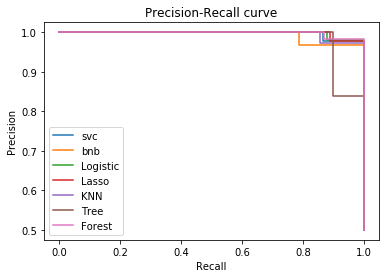

In [123]:
plt.step(svc_train_recall, svc_train_precision, label = 'svc')
plt.step(bnb_train_recall, bnb_train_precision, label = 'bnb')
plt.step(log_train_recall, log_train_precision, label ='Logistic')
plt.step(lasso_train_recall, lasso_train_precision, label ='Lasso')
plt.step(knn_train_recall, knn_train_precision, label = 'KNN')
plt.step(decision_tree_train_recall, decision_tree_train_precision, label = 'Tree')
plt.step(rfc_train_recall, rfc_train_precision, label = 'Forest')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

# Conclusion

As a conclusion, Random Forest Classifier did best. Knowing the question and this information, I would suggest that the credit card company use the Random Forest Classifier model with this data.